In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
vmax = 1        # full velocity at crossing
amax = 0.5      # maximum acceleration/deceleration
L = 1           # follow distance
rho = L / vmax  # follow time

In [3]:
def interval_controller(amax, *intervals):
    def evaluate(t):
        a = 0
        for ix, i in enumerate(intervals):
            if i[0] <= t < i[1]:
                a = -amax if (ix % 2 == 0) else amax
        return a

    return evaluate

def double_integrator(control):
    return lambda t, y: (y[1], control(t))

## Schedule time to regular time

In [4]:
T = vmax / amax
t = np.linspace(0, T, num=100)

In [5]:
def acceleration(t):
    return t*t * amax / 2

In [6]:
def t_bar(t, x):
    return t - x / vmax

In [7]:
def line(bar):
    return lambda t: (t - bar) * vmax

In [8]:
def t1_acc(v_c, d_bar):
    t0 = v_c / amax
    return T - math.sqrt(T*T - 2*T*(t0 + d_bar) + t0*t0)
def duration_acc(v_c, d_bar):
    t0 = v_c / amax
    return t1_acc(v_c, d_bar) - t0

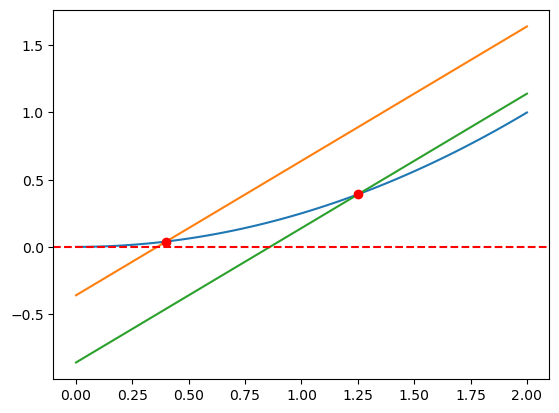

In [20]:
def plot_acceleration(v_c, d_bar):
    t0 = v_c / amax
    
    plt.plot(t, acceleration(t))
    plt.plot(t, line(t_bar(t0, acceleration(t0)))(t))
    plt.plot(t0, acceleration(t0), 'ro')
    t1 = t1_acc(v_c, d_bar)
    plt.plot(t, line(t_bar(t1, acceleration(t1)))(t))
    plt.plot(t1, acceleration(t1), 'ro')
    plt.axhline(y=0, color='r', linestyle='--')
plot_acceleration(0.2, 0.5)

In [10]:
def t1_dec(v_c, d_bar):
    t0 = -v_c / amax
    return -T + math.sqrt(T*T + 2*T*(t0 + d_bar) + t0*t0)
def duration_dec(v_c, d_bar):
    t0 = -v_c / amax
    return t1_dec(v_c, d_bar) - t0

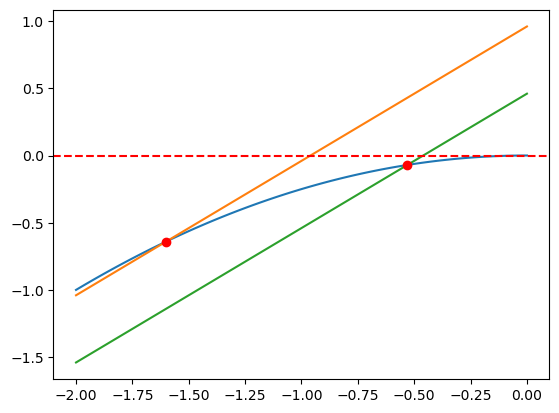

In [21]:
def plot_deceleration(v_c, d_bar):
    t0 = -v_c / amax
    
    plt.plot(-t, -acceleration(t))
    plt.plot(-t, line(t_bar(t0, -acceleration(t0)))(-t))
    plt.plot(t0, -acceleration(t0), 'ro')
    t1 = t1_dec(v_c, d_bar)
    plt.plot(-t, line(t_bar(t1, -acceleration(t1)))(-t))
    plt.plot(t1, -acceleration(t1), 'ro')
    plt.axhline(y=0, color='r', linestyle='--')
plot_deceleration(vmax-0.2, 0.5)

## Explicit expression for single trajectory

In [22]:
def simple_trajectory_intervals(b, e):
    t_n = max(0, e - b - T)
    t_b_bar = (e - b - t_n) / 2

    d_dec = duration_dec(vmax, t_b_bar)
    vc = vmax - d_dec * amax
    d_acc = duration_acc(vc, t_b_bar)
    
    return [[b, b+d_dec], [b+d_dec+t_n, b+d_dec+t_n+d_acc]]

def simple_trajectory(b, e):
    intervals = simple_trajectory_intervals(b, e)

    control = interval_controller(amax, *intervals)

    tr = solve_ivp(double_integrator(control), [0, 15], [-b*vmax, vmax], max_step=0.01)

    plt.plot(tr.t, tr.y[0,:])
    return tr

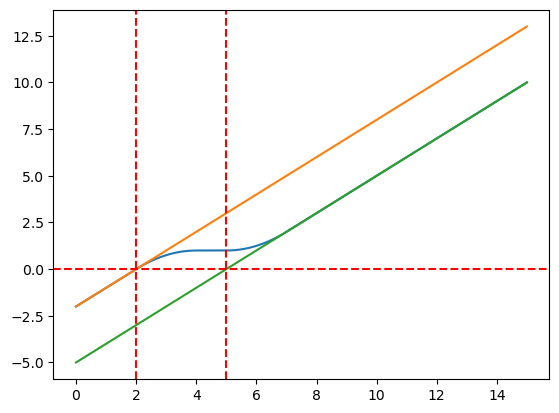

In [23]:
b, e = 2, 5

tr = simple_trajectory(b, e)
plt.plot(tr.t, line(t_bar(b, 0))(tr.t))
plt.plot(tr.t, line(t_bar(e, 0))(tr.t))
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=b, color='r', linestyle='--')
plt.axvline(x=e, color='r', linestyle='--');

## Translate to regular time

[[4.0, 6.0], [8.0, 8.904554884989668], [8.904554884989668, 9.809109769979337], [11.409109769979336, 13.409109769979336]]


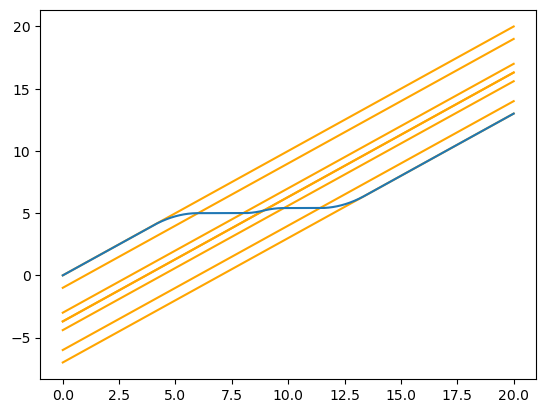

In [29]:
schedule_intervals = [[0, 1], [3, 3.7], [3.7, 4.4], [6, 7]]

def translate(schedule_intervals, target_height, vc=vmax):
    """vc = initial velocity"""
    intervals = []
    arrival = schedule_intervals[0][0]
    t = arrival + (target_height - acceleration(T)) / vmax
    prev = arrival
    for ix, (a, b) in enumerate(schedule_intervals):
        if prev != a:
            # duration when velocity is constant
            t += (a - prev) * vmax / (vmax - vc)
        if ix % 2 == 0:
            d = duration_dec(vc, b - a)
            vc -= d * amax
        else:
            d = duration_acc(vc, b - a)
            vc += d * amax

        intervals.append([t, t+d])
        t+=d
        prev = b

    return intervals
    
intervals = translate(schedule_intervals, 5)
control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [-schedule_intervals[0][0]*vmax, vmax], max_step=0.001)

for a, b in schedule_intervals:
    plt.plot(tr.t, line(t_bar(a, 0))(tr.t), 'orange')
    plt.plot(tr.t, line(t_bar(b, 0))(tr.t), 'orange')

plt.plot(tr.t, tr.y[0,:]);

## Next target position

In [39]:
t_hat = math.sqrt(L / amax) - L / 2 / vmax

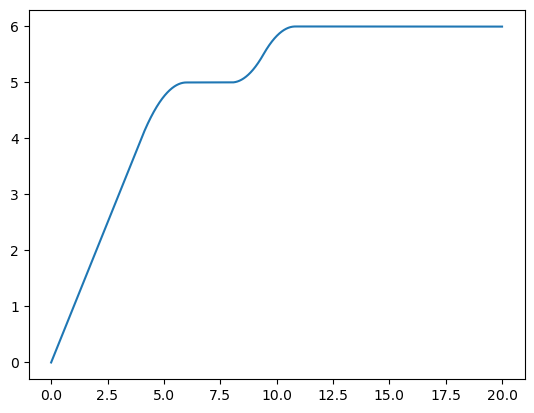

In [40]:
schedule_intervals = [[0, 1], [3, 3+t_hat], [3+t_hat, 3+2*t_hat]]
intervals = translate(schedule_intervals, 5)
control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [-schedule_intervals[0][0]*vmax, vmax], max_step=0.001)

plt.plot(tr.t, tr.y[0,:]);